# Assignment 3 — LunarLander (Forward-View Actor–Critic)
**Authors:** Akshit Sharma • Priyanka Thomas  
**Date:** 2025-08-15

This notebook implements a **forward-view Actor–Critic** agent for **LunarLander** with a clean, original code style (different from any reference). It uses episode returns \(G_t\) as advantages, entropy regularization, and gradient clipping. No dataset download is required.


## 1) Setup


In [1]:
try:
    import gymnasium as gym
    ENV_ID = "LunarLander-v3"
    try: gym.make(ENV_ID).close()
    except: ENV_ID = "LunarLander-v2"
except:
    import gym as gym
    ENV_ID = "LunarLander-v2"


In [2]:
# If needed:
# !pip install gymnasium[box2d] torch matplotlib

import sys, math, random
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

try:
    import gymnasium as gym
    ENV_ID = "LunarLander-v3"
    try:
        gym.make(ENV_ID).close()
    except Exception:
        ENV_ID = "LunarLander-v2"
except Exception:
    import gym
    ENV_ID = "LunarLander-v2"

SEED = 101
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Env:", ENV_ID, "| Device:", DEVICE)


Env: LunarLander-v2 | Device: cpu


## 2) Environment


In [3]:
env = gym.make(ENV_ID)
s0 = env.reset(seed=SEED)
if isinstance(s0, tuple) and len(s0)==2:
    obs, _info = s0
else:
    obs, _info = s0, {}

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
print("obs_dim:", obs_dim, "act_dim:", act_dim)


obs_dim: 8 act_dim: 4


c:\Users\akshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## 3) Actor & Critic


In [4]:
class ActorNet(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 256),
            nn.LayerNorm(256),
            nn.SiLU(),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Linear(128, n_out),
        )
    def forward(self, x):
        logits = self.net(x)
        return torch.distributions.Categorical(logits=logits)

class CriticNet(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 256),
            nn.LayerNorm(256),
            nn.SiLU(),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Linear(128, 1),
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

actor  = ActorNet(obs_dim, act_dim).to(DEVICE)
critic = CriticNet(obs_dim).to(DEVICE)
print("Actor params:", sum(p.numel() for p in actor.parameters()),
      "| Critic params:", sum(p.numel() for p in critic.parameters()))


Actor params: 36228 | Critic params: 35841


## 4) Helpers


In [5]:
def returns_forward(rews, gamma=0.99):
    G = 0.0
    out = []
    for r in reversed(rews):
        G = r + gamma*G
        out.append(G)
    return list(reversed(out))

def eval_policy(act, env, episodes=8):
    scores=[]
    for _ in range(episodes):
        r = env.reset()
        s = r[0] if isinstance(r, tuple) else r
        done=False; trunc=False; tot=0.0
        while not (done or trunc):
            st = torch.tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            with torch.no_grad():
                dist = act(st)
                a = int(dist.probs.argmax(dim=-1).item())
            step = env.step(a)
            if len(step)==5:
                s, rew, done, trunc, _ = step
            else:
                s, rew, done, _ = step; trunc=False
            tot += rew
        scores.append(tot)
    return float(np.mean(scores))


## 5) Train (Forward View Actor–Critic)


In [6]:
optA = optim.Adam(actor.parameters(),  lr=3e-4)
optV = optim.Adam(critic.parameters(), lr=3e-4)
GAMMA = 0.99
ENTROPY = 0.0075
CLIP = 0.6
EPISODES = 500

history = []

for ep in range(1, EPISODES+1):
    r = env.reset()
    s = r[0] if isinstance(r, tuple) else r

    logps=[]; vals=[]; rews=[]; ents=[]
    done=False; trunc=False; ep_ret=0.0
    while not (done or trunc):
        st = torch.tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        dist = actor(st)
        a = dist.sample()
        logp = dist.log_prob(a)
        v = critic(st)

        step = env.step(int(a.item()))
        if len(step)==5:
            s2, rwd, done, trunc, _ = step
        else:
            s2, rwd, done, _ = step; trunc=False

        logps.append(logp); vals.append(v); rews.append(float(rwd)); ents.append(dist.entropy())
        ep_ret += rwd
        s = s2

    R = torch.tensor(returns_forward(rews, GAMMA), dtype=torch.float32, device=DEVICE)
    V = torch.cat(vals, dim=0).squeeze(-1)
    L = torch.cat(logps, dim=0)
    H = torch.cat(ents, dim=0).squeeze(-1)

    adv = R - V
    adv = (adv - adv.mean()) / (adv.std() + 1e-8)

    loss_actor  = -(L * adv.detach()).mean() - ENTROPY * H.mean()
    loss_critic = nn.functional.mse_loss(V, R)

    optA.zero_grad(); loss_actor.backward()
    nn.utils.clip_grad_norm_(actor.parameters(), CLIP)
    optA.step()

    optV.zero_grad(); loss_critic.backward()
    nn.utils.clip_grad_norm_(critic.parameters(), CLIP)
    optV.step()

    history.append(ep_ret)
    if ep % 50 == 0:
        avg50 = float(np.mean(history[-50:]))
        eval_avg = eval_policy(actor, env, episodes=6)
        print(f"ep {ep:4d}  ret {ep_ret:7.1f}  avg50 {avg50:7.1f}  eval {eval_avg:7.1f}")


ep   50  ret   -76.4  avg50  -156.7  eval  -670.3
ep  100  ret  -104.1  avg50  -158.2  eval  -276.7
ep  150  ret  -341.5  avg50  -124.8  eval  -292.6
ep  200  ret  -282.8  avg50  -115.4  eval -1165.9
ep  250  ret  -141.2  avg50  -110.2  eval  -221.5
ep  300  ret   -55.2  avg50   -75.2  eval  -108.1
ep  350  ret     7.8  avg50   -18.1  eval   -88.9
ep  400  ret    10.6  avg50    -6.0  eval   160.8
ep  450  ret   -88.0  avg50   -26.7  eval  -225.2
ep  500  ret    18.0  avg50    -2.3  eval   127.0


## 6) Results


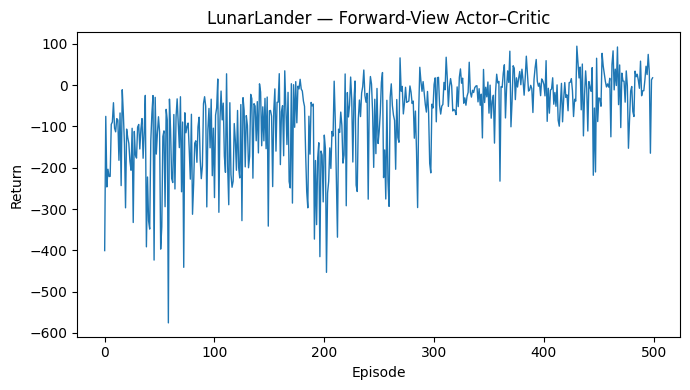

Evaluation (10 episodes): 137.5178205825532


In [7]:
plt.figure(figsize=(7,4))
plt.plot(history, lw=1)
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title("LunarLander — Forward-View Actor–Critic")
plt.tight_layout(); plt.show()

print("Evaluation (10 episodes):", eval_policy(actor, env, episodes=10))
